In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import fields, replace, asdict
import pickle
from statsmodels.api import OLS

import sys
sys.path.insert(0,'../../') # just for jupyter  notebook
from stochvolmodels.pricers.hawkes_jd_pricer import HawkesJDParams, HawkesJDPricer, hawkesjd_chain_pricer, unpack_and_transform_pars_for_measure_change, unpack_pars

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from stochvolmodels.utils.funcs import transform_from_tfcomplex128_to_np, slice_option_chain
import warnings
warnings.filterwarnings('ignore')

In [6]:
def jump_compensators(nu, eta, side):
    if side == 'p':
        return np.exp(nu)/(1-eta)-1
    elif side == 'm':
        return np.exp(nu)/(1+eta)-1

positive_jump_compensator = lambda nu_p, eta_p: jump_compensators(nu_p, eta_p, 'p')
negative_jump_compensator = lambda nu_m, eta_m: jump_compensators(nu_m, eta_m, 'm')


In [7]:
# OLD params
# P_params = pd.read_csv('P_params_daily.csv', index_col=0)
# Q_params = pd.read_csv('Q_params_daily.csv', index_col=0)

P_params = pd.read_csv('P_params.csv', index_col=0)
P_params.index = pd.Series(P_params.index).apply(lambda x: x[:10])
P_params.index = pd.to_datetime(P_params.index)

with open("Q_results_refined.pickle", "rb") as f: 
    Q_results = pickle.load(f)
    
Q_params = dict()
for date in Q_results:
    d = asdict(transform_from_tfcomplex128_to_np(Q_results[date]['measure_change_results']))
    
    d['is_pos_jump'] = Q_results[date]['is_pos_jump']
    d['is_neg_jump'] = Q_results[date]['is_neg_jump']
    if Q_results[date]['MAPE'] <= 2:
        Q_params[date] = d
    
Q_params = pd.DataFrame(Q_params).T
Q_params.index = pd.to_datetime(Q_params.index)
Q_params = Q_params.astype(np.float64)

In [8]:
def gen_jumps_premia(Q_params, P_params):
    pjp = Q_params.lambda_p * positive_jump_compensator(Q_params.nu_p, Q_params.eta_p) - P_params.lambda_p_right * positive_jump_compensator(P_params.nu_p, P_params.eta_p)
    njp = Q_params.lambda_m * negative_jump_compensator(Q_params.nu_m, Q_params.eta_m) - P_params.lambda_m_right * negative_jump_compensator(P_params.nu_m, P_params.eta_m)
    # pjp*= Q_params.sigma
    # njp*= Q_params.sigma

    pjp.index = pd.to_datetime(pjp.index)
    njp.index = pd.to_datetime(njp.index)
    pjp.name = 'pjp'
    njp.name = 'njp'
    return pjp.dropna(), njp.dropna()

In [9]:
def gen_background_jumps_premia(Q_params, P_params):
    pjp = Q_params.theta_p * positive_jump_compensator(Q_params.nu_p, Q_params.eta_p) - P_params.theta_p * positive_jump_compensator(P_params.nu_p, P_params.eta_p)
    njp = Q_params.theta_m * negative_jump_compensator(Q_params.nu_m, Q_params.eta_m) - P_params.theta_m * negative_jump_compensator(P_params.nu_m, P_params.eta_m)
    # pjp*= Q_params.sigma
    # njp*= Q_params.sigma

    pjp.index = pd.to_datetime(pjp.index)
    njp.index = pd.to_datetime(njp.index)
    pjp.name = 'background_pjp'
    njp.name = 'background_njp'
    return pjp.dropna(), njp.dropna()

In [19]:
merged = merged_daily

def gen_regression_result(merged, regression=0, k=7*16, portfolio ='spot', rolling=1, return_data_only = False, nonoverlap=False):
    y = np.log(merged.loc[:,portfolio].shift(-k)/merged.loc[:,portfolio])*1000
    x0 = np.log(merged.loc[:,portfolio]/merged.loc[:,portfolio].shift(k))*1000
    x1 = merged.loc[:, 'pjp'].rolling(rolling).mean()
    x2 = merged.loc[:, 'njp'].rolling(rolling).mean()
    x3 = merged.loc[:, 'lambda_p_right']
    x4 = merged.loc[:, 'lambda_m_right'] 
    x5 = x1+x2
    x6 = x3+x4
    x7 = x1-x2
    x8 = merged.loc[:, 'self_pjp'].rolling(rolling).mean()
    x9 = merged.loc[:, 'self_njp'].rolling(rolling).mean()
    x10 = merged.loc[:, 'background_pjp'].rolling(rolling).mean()
    x11 = merged.loc[:, 'background_njp'].rolling(rolling).mean()
    
    t = merged.loc[:,'t']
    
    data_for_regression = pd.DataFrame([y, t, x0, 
                                        x1, x2, 
                                        x3, x4, 
                                        x5, x6, x7,
                                        x8, x9, x10, x11]).T    
    
    data_for_regression = data_for_regression.loc[data_for_regression.isna().sum(axis=1) == 0]
    data_for_regression.columns = ['y', 't', 'y_t_minus_Delta', 
                                   'pjp', 'njp',  
                                   'lambda_p', 'lambda_m', 
                                   'lambdas_sum', 'jps_sum', 'jps_diff',
                                   'self_pjp', 'self_njp', 'background_pjp', 'background_njp']
    
    data_for_regression.loc[:,'intercept'] = 1
    
    if return_data_only:
        return data_for_regression
    
    if nonoverlap:
        data_for_regression = data_for_regression[::k]
    
    if regression == 0:
        r = OLS(data_for_regression.y, data_for_regression.loc[:, ['intercept', 't', 'y_t_minus_Delta', 'pjp', 'njp']]).fit()
    elif regression == 1:
        r = OLS(data_for_regression.y, data_for_regression.loc[:, ['intercept', 't', 'y_t_minus_Delta', 'lambda_p', 'lambda_m']]).fit()
    elif regression == 2:
        r = OLS(data_for_regression.y, data_for_regression.loc[:, ['intercept', 't', 'y_t_minus_Delta', 'pjp', 'njp', 'lambda_p', 'lambda_m']]).fit()
    elif regression == 3:
        r = OLS(data_for_regression.y, data_for_regression.loc[:, ['intercept', 't', 'y_t_minus_Delta', 'jps_sum', 'lambdas_sum']]).fit()
    elif regression == 4:
        r = OLS(data_for_regression.y, data_for_regression.loc[:, ['intercept', 't', 'y_t_minus_Delta', 'jps_diff','lambdas_sum']]).fit()
        
    elif regression == 5:
        r = OLS(data_for_regression.y, data_for_regression.loc[:, ['intercept', 't', 'y_t_minus_Delta', 'njp']]).fit()

    return r

In [20]:
k_arr = np.arange(1, 60, 1) 
portfolio = 'Long ATM Put'

k = 10

r_df_daily_arr = []

for regression in [0,1,2,3,4]:
    r = gen_regression_result(merged_daily, k=k, regression=regression, portfolio=portfolio, nonoverlap=False)
    _index = r.params.index
    r = r.get_robustcov_results(cov_type='HAC', maxlags=2*k)

    df = pd.DataFrame(
        [[k, '', ''], [k, '', 'R2=%.4f'%np.round(r.rsquared, 4)]],
        columns=["Lag (days)", '', ''],
    )

    _params = pd.Series(np.round(r.params, 4), index=_index)
    _pvalues = pd.Series(np.round(r.pvalues, 2), index=_index)
    _rsqaured = pd.Series(np.round(r.rsquared, 4), index=['rsqaured'])
    r_df = pd.concat([_params, _pvalues], axis=1)
    
    r_df.columns = pd.MultiIndex.from_frame(df)

    r_df_daily_arr.append(r_df)
    
r_df_daily = pd.concat(r_df_daily_arr, axis=1)


In [21]:
r_df_daily.T.fillna('')

intercept       t  y_t_minus_Delta     pjp     njp  \
Lag (days)                                                                  
10                      -16.8819  2.3708          -0.0915 -0.9944  3.5009   
            R2=0.0596     0.0000  0.0300           0.1400    0.67    0.06   
                          1.8925 -0.1660          -0.1222                   
            R2=0.1672     0.6800  0.8700           0.0700                   
                          1.3346 -0.0618          -0.1094 -1.0383   1.528   
            R2=0.1708     0.7900  0.9500           0.1000    0.49    0.38   
                         -1.3487  0.2179          -0.0853                   
            R2=0.1629     0.7600  0.8300           0.1600                   
                        -16.8819  2.3708          -0.0915                   
            R2=0.0596     0.0000  0.0300           0.1400                   

                      lambda_p lambda_m jps_sum lambdas_sum jps_diff  
Lag (days)                                                            
10                                                                    
            R2=0.0596                                                 
                        0.1937  -0.6274                               
            R2=0.1672     0.56     0.06                               
                        0.1199  -0.5376                               
            R2=0.1708     0.73     0.13                               
                                        -0.2129      0.4668           
            R2=0.1629                       0.0        0.46           
                                                     1.2532  -2.2477  
            R2=0.0596                                  0.17     0.25

In [22]:
print(r_df_daily.fillna('').T.to_latex())

\begin{tabular}{lllllllllllll}
\toprule
   & {} &           & intercept &       t & y\_t\_minus\_Delta &     pjp &     njp & lambda\_p & lambda\_m & jps\_sum & lambdas\_sum & jps\_diff \\
Lag (days) & {} & {} &           &         &                 &         &         &          &          &         &             &          \\
\midrule
10 & {} &           &  -16.8819 &  2.3708 &         -0.0915 & -0.9944 &  3.5009 &          &          &         &             &          \\
   & {} & R2=0.0596 &       0.0 &    0.03 &            0.14 &    0.67 &    0.06 &          &          &         &             &          \\
   & {} &           &    1.8925 &  -0.166 &         -0.1222 &         &         &   0.1937 &  -0.6274 &         &             &          \\
   & {} & R2=0.1672 &      0.68 &    0.87 &            0.07 &         &         &     0.56 &     0.06 &         &             &          \\
   & {} &           &    1.3346 & -0.0618 &         -0.1094 & -1.0383 &   1.528 &   0.1199 &  -0.5376 

In [23]:
r_df_daily_arr = []
r = gen_regression_result(merged, k=1, regression=regression, portfolio=portfolio)
_index = r.params.index
k=3
for k in k_arr:
    r = gen_regression_result(merged_daily, k=k, regression=regression, portfolio=portfolio, nonoverlap=False).get_robustcov_results(cov_type='HAC', maxlags=2*k)
    # r = gen_rev_regression_result(merged_daily, k=k, regression=regression, portfolio='BTC', nonoverlap=False)

    df = pd.DataFrame(
        [[k, 'coef', ''], [k, 'pvalue', 'RS=%.4f'%np.round(r.rsquared, 4)]],
        columns=["Lag (days)", '', ''],
    )

    _params = pd.Series(np.round(r.params, 4), index=_index)
    _pvalues = pd.Series(np.round(r.pvalues, 2), index=_index)
    r_df = pd.concat([_params, _pvalues], axis=1)
    
    # df = pd.DataFrame(
    #     [[k, 'coef', ''], [k, 'tvalue', 'RS=%.4f'%np.round(r.rsquared, 4)]],
    #     columns=["Lag (days)", '', ''],
    # )

    # r_df = pd.concat([np.round(r.params, 4), np.round(r.tvalues/np.sqrt(k), 2)], axis=1)
    
    r_df.columns = pd.MultiIndex.from_frame(df)
    
    r_df_daily_arr.append(r_df)
    
r_df_daily = pd.concat(r_df_daily_arr, axis=1)

In [24]:
# k = 60
# r = gen_regression_result(merged_daily, k=k, regression=regression, portfolio='Long 25D Call', nonoverlap=False).get_robustcov_results(cov_type='HAC', maxlags=2*k)
# # r = gen_rev_regression_result(merged_daily, k=k, regression=regression, portfolio='BTC', nonoverlap=False)
# r.wald_test('pjp=0, njp=0, lambda_p=0, lambda_m=0, t=0, y_t_minus_Delta = 0').pvalue

In [25]:
params_arr = []
lower_q_arr = []
upper_q_arr = []
rsquared_arr = []

regression = 5
portfolio = 'Short 25D Put'
k_arr = np.arange(1, 120, 1)

merged = merged_daily
alpha = 0.1
r = gen_regression_result(merged, k=1, regression=regression, portfolio=portfolio)
_index = r.params.index
for k in k_arr:
    r = gen_regression_result(merged, k=k, regression=regression, portfolio=portfolio).get_robustcov_results(cov_type='HAC', maxlags=2*k)
    # r = gen_regression_result(merged, k=k, regression=regression, portfolio=portfolio)

    params = pd.DataFrame(r.params, index=_index, columns=[k])
    conf_int = pd.DataFrame(r.conf_int(alpha=alpha), index=_index)
    conf_int.columns = ['lower_q', 'upper_q']
    lower_q = conf_int.lower_q
    upper_q = conf_int.upper_q
    
    lower_q.name = k
    upper_q.name = k

    params_arr.append(params)
    lower_q_arr.append(lower_q)
    upper_q_arr.append(upper_q)
    rsquared_arr.append(r.rsquared)
    
params_arr = pd.concat(params_arr, axis=1)
upper_q_arr = pd.concat(upper_q_arr, axis=1)
lower_q_arr = pd.concat(lower_q_arr, axis=1)

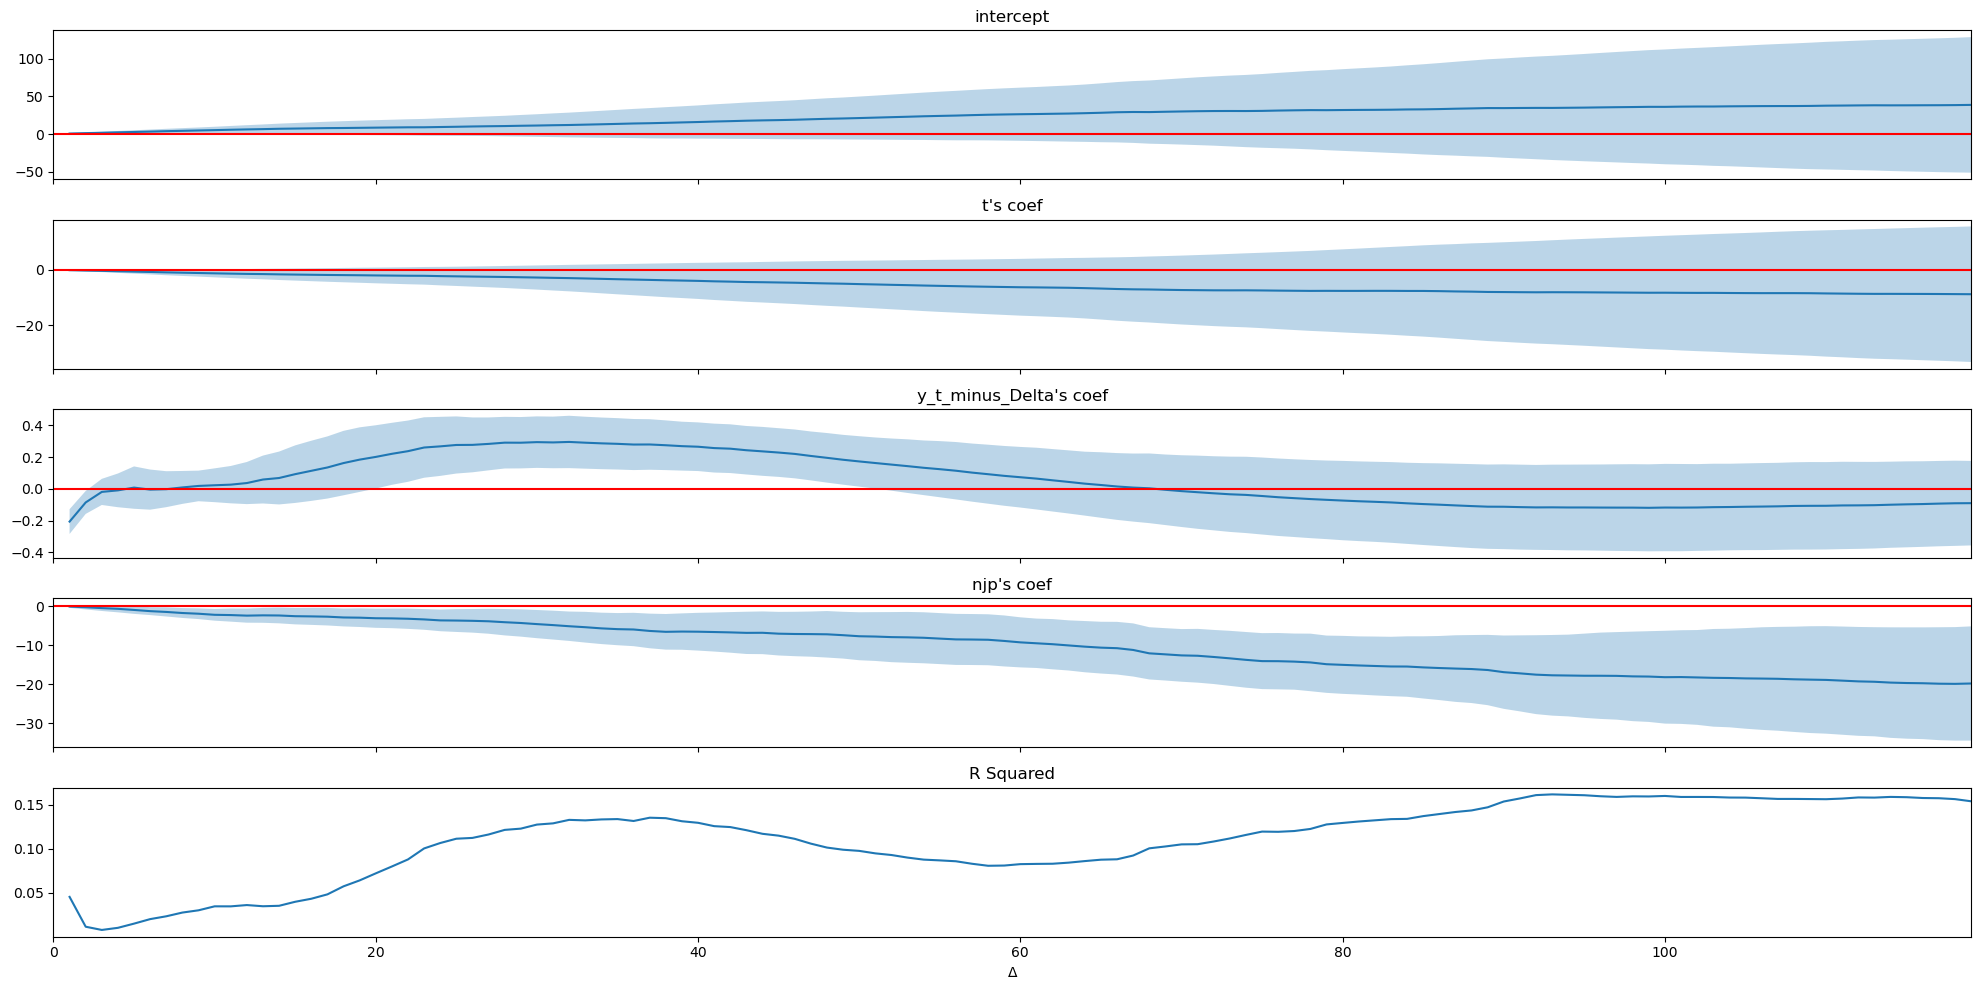

In [26]:
fig, axs = plt.subplots(len(params_arr)+1, 1, sharex=True, figsize=(20, 2*(len(params_arr)+1)))

axs = axs.flatten()
for i, name in enumerate(params_arr.index):
    if i==0:
        axs[i].set_title(name)
    else:
        axs[i].set_title(name+"'s coef")

    axs[i].plot(params_arr.columns, params_arr.loc[name,:], label='coef')
    axs[i].fill_between(params_arr.columns, lower_q_arr.loc[name,:], upper_q_arr.loc[name,:], alpha=0.3, label='%.2f confidence interval'%(1-alpha))
    axs[i].hlines(0, 0, params_arr.columns[-1], color='red')
    # axs[i].legend()
    # axs[i].legend()
    
axs[i].set_xlim(0, max(params_arr.columns))
    
axs[-1].set_title('R Squared')
axs[-1].plot(k_arr, rsquared_arr)

axs[-1].set_xlabel(r'$\Delta$')

# axs[-1].set_ylim(0,.12)
plt.tight_layout()

# plt.savefig('regression%s.png'%regression, transparent=True)

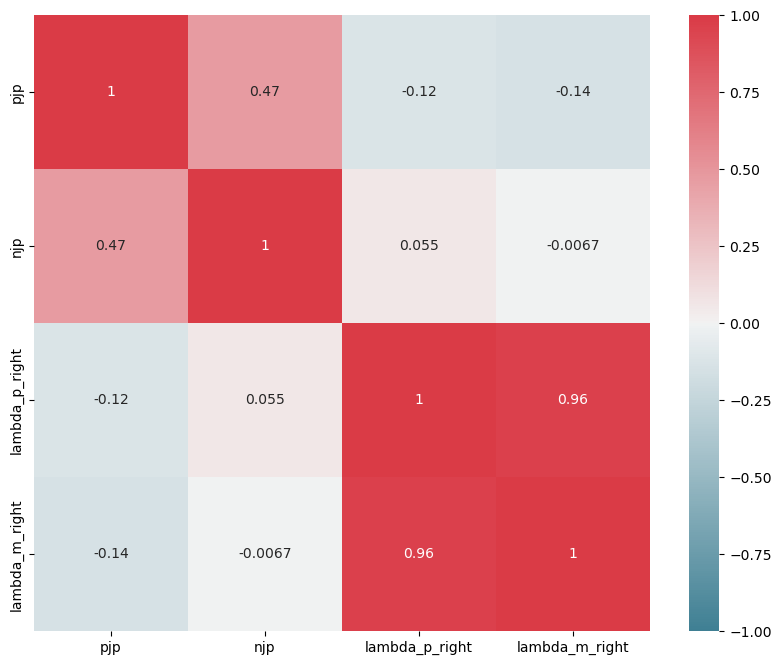

In [27]:
df = merged_daily.loc[:,['pjp', 'njp', 'lambda_p_right', 'lambda_m_right']]

# df = merged_daily.loc[:, ['self_pjp', 'self_njp', 'background_pjp', 'background_njp', 'lambda_p_right', 'lambda_m_right']]

df = df - df.shift(1) 
df = df.loc[df.isna().sum(axis=1) == 0]
corr = df.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr,annot=True,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

plt.savefig('corr.png', transparent=True)

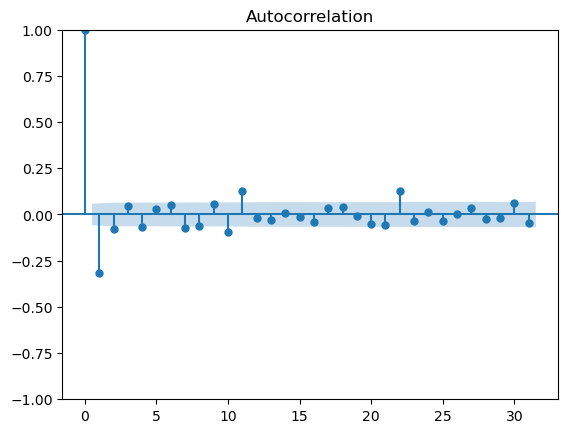

In [28]:
plot_acf(df.njp)
plt.show()

In [29]:
# is_pos_jump = pd.Series([Q_results[date]['is_pos_jump'] for date in Q_results], index=Q_results.keys())
# is_neg_jump = pd.Series([Q_results[date]['is_neg_jump'] for date in Q_results], index=Q_results.keys())

# is_pos_jump.index = pd.to_datetime(is_pos_jump.index)
# is_neg_jump.index = pd.to_datetime(is_neg_jump.index)

# is_pos_jump.name = 'is_pos_jump'
# is_neg_jump.name = 'is_neg_jump'

# jumps = merged_daily.merge(is_pos_jump, how='right')
# jumps = jumps.merge(is_neg_jump, how='right')

# jumps = jumps[jumps.isna().sum(axis=1) == 0]

# # sns.distplot(jumps.pjp)
# # sns.distplot(jumps.njp)

In [30]:
from statsmodels.tsa.api import VAR, VECM

In [31]:
portfolio = 'spot'
k = 1
y = np.log(merged.loc[:,portfolio]/merged.loc[:,portfolio].shift(1))
x0 = (np.log(merged.loc[:,portfolio]/merged.loc[:,portfolio].shift(1))*1000).rolling(k).sum()
x1 = merged.loc[:, 'pjp'].rolling(k).sum()
x2 = merged.loc[:, 'njp'].rolling(k).sum()
x3 = merged.loc[:, 'lambda_p_right'].rolling(k).sum()
x4 = merged.loc[:, 'lambda_m_right'] .rolling(k).sum()
x5 = x1+x2
x6 = x3+x4
x7 = x1-x2
x8 = merged.loc[:, 'self_pjp'].rolling(k).sum()
x9 = merged.loc[:, 'self_njp'].rolling(k).sum()
x10 = merged.loc[:, 'background_pjp'].rolling(k).sum()
x11 = merged.loc[:, 'background_njp'].rolling(k).sum()

t = merged.loc[:,'t'] 

data_for_regression = pd.DataFrame([y, t, x0, 
                                    x1, x2, 
                                    x3, x4, 
                                    x5, x6, x7,
                                    x8, x9, x10, x11]).T    

data_for_regression = data_for_regression.loc[data_for_regression.isna().sum(axis=1) == 0]
data_for_regression.columns = ['y', 't', 'y_t_minus_Delta', 
                                'pjp', 'njp',  
                                'lambda_p', 'lambda_m', 
                                'lambdas_sum', 'jps_sum', 'jps_diff',
                                'self_pjp', 'self_njp', 'background_pjp', 'background_njp']

# _data_for_regression = data_for_regression.loc[:,['y', 'pjp', 'njp', 'lambda_p', 'lambda_m']]
_data_for_regression = data_for_regression.loc[:,['y', 'pjp', 'njp']]
# _data_for_regression = data_for_regression.loc[:,['y', 'jps_diff']]

In [32]:
# model = VECM(_data_for_regression, k_ar_diff=150, deterministic='co')
# results = model.fit()

AIC = dict()
for k in range(1,120):
    model = VAR(_data_for_regression)
    results = model.fit(k)
    AIC[k]=results.aic
AIC = pd.Series(AIC)
# resid = results.resid
# pd.DataFrame(np.corrcoef(resid.T), index=_data_for_regression.columns, columns=_data_for_regression.columns)

36


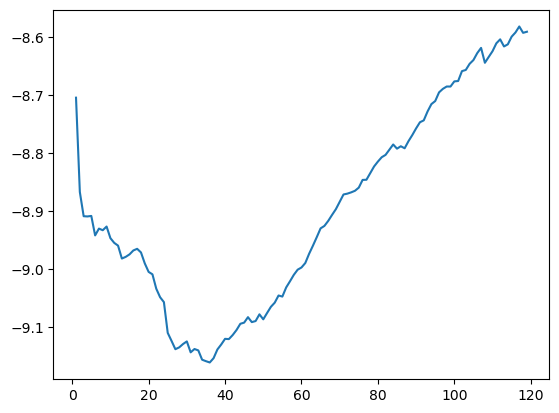

In [33]:
plt.plot(AIC)
k = AIC.idxmin()
print(k)

In [42]:
model = VAR(_data_for_regression)
results = model.fit(k)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Nov, 2023
Time:                     10:05:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -7.67138
Nobs:                     1098.00    HQIC:                  -8.59730
Log likelihood:           682.307    FPE:                0.000105284
AIC:                     -9.16082    Det(Omega_mle):     7.92585e-05
--------------------------------------------------------------------
Results for equation y
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.000398         0.001592           -0.250           0.802
L1.y            0.013509         0.034466            0.392           0.695
L1.pjp          0.004014         0.003042            1.319           0.187
L1.njp       

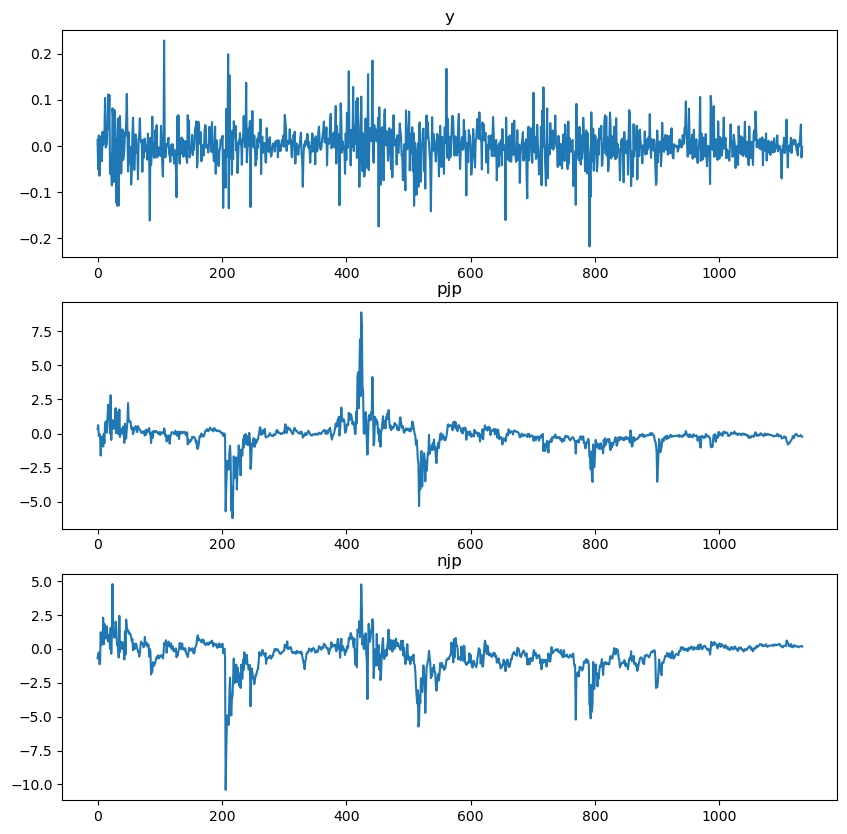

In [43]:
results.plot()
plt.show()

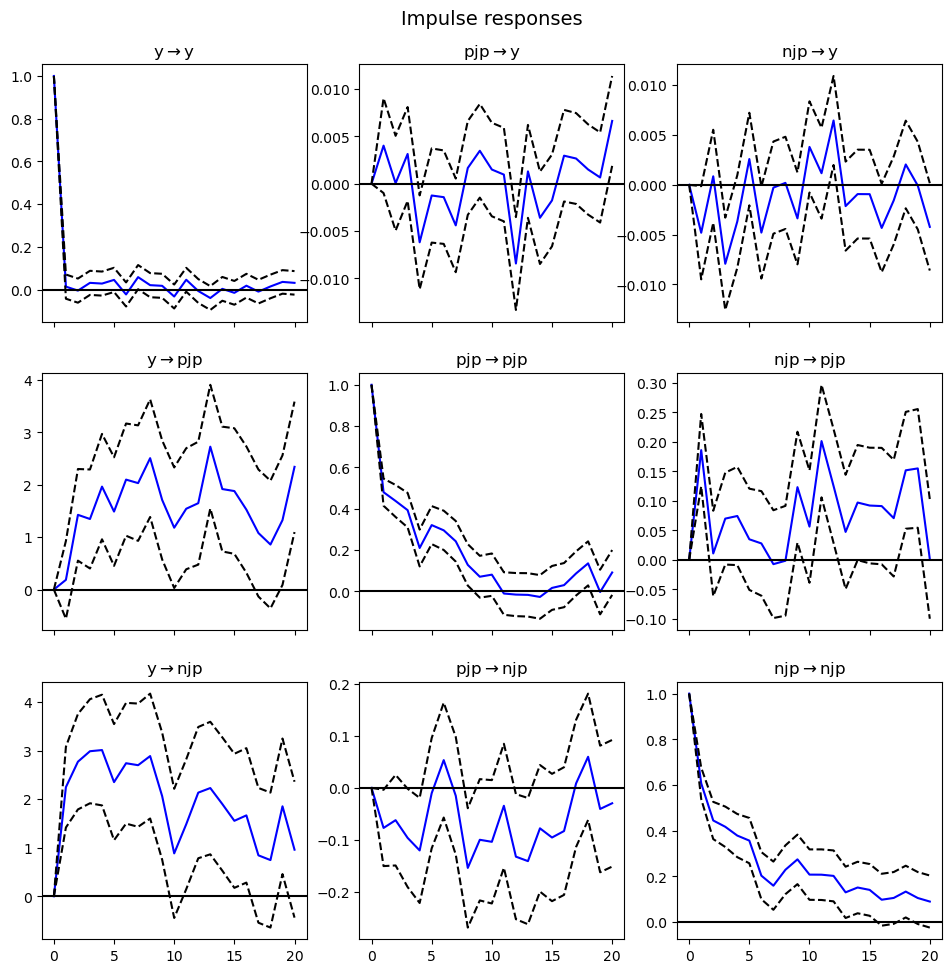

In [44]:
irf = results.irf(20)
irf.plot(orth=False, figsize=(10,10), signif=0.1)

# irf.plot(orth=True,  impulse = 'lambda_p', response='pjp', signif=0.1, figsize=(4,4), subplot_params={'fontsize' : 0})
# irf.plot(orth=True,  impulse = 'lambda_m', response='pjp', signif=0.1, figsize=(4,4), subplot_params={'fontsize' : 0})
# irf.plot(orth=True, signif=0.1)

# irf.plot_cum_effects(orth=True,  impulse = 'lambda_m', response='njp', signif=0.1)
plt.show()

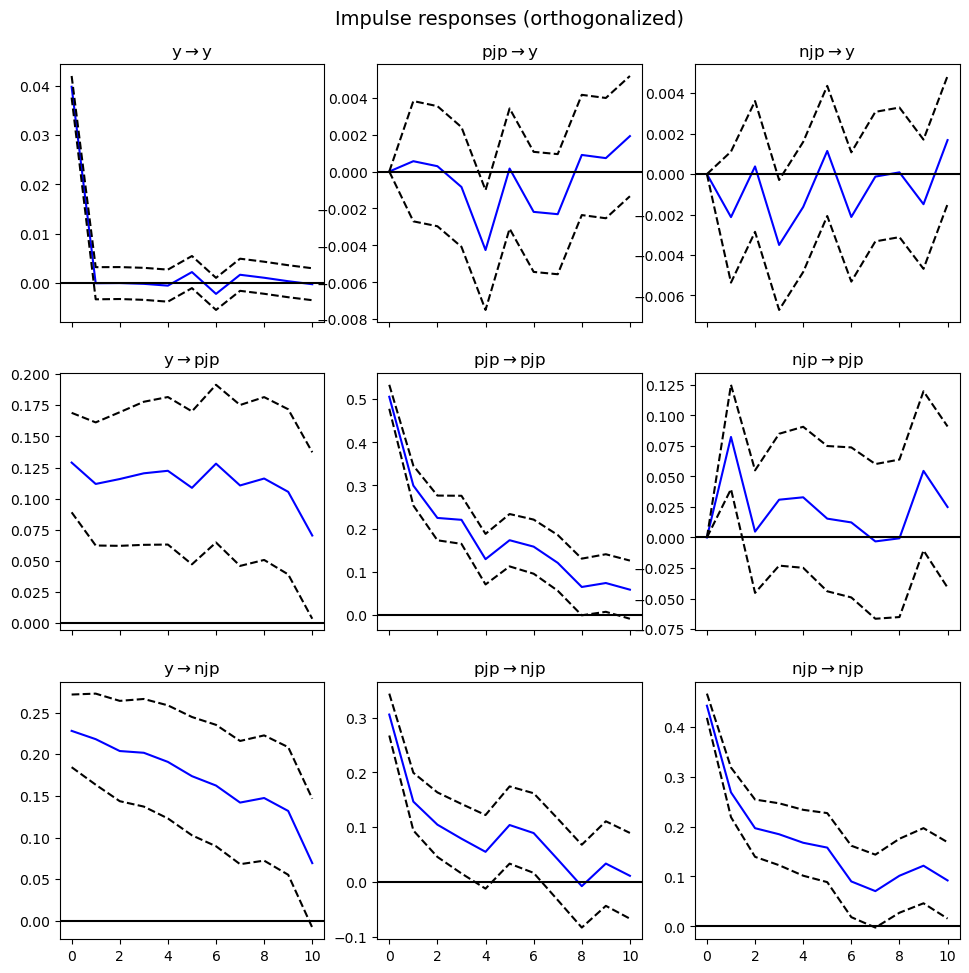

In [50]:
irf = results.irf(10)
irf.plot(orth=True, figsize=(10,10), signif=0.01)

# orth=True causal 
# irf.plot(orth=True,  impulse = 'lambda_p', response='pjp', signif=0.1, figsize=(4,4), subplot_params={'fontsize' : 0})
# irf.plot(orth=True,  impulse = 'lambda_m', response='pjp', signif=0.1, figsize=(4,4), subplot_params={'fontsize' : 0})
# irf.plot(orth=True, signif=0.1)

# irf.plot_cum_effects(orth=True,  impulse = 'lambda_m', response='njp', signif=0.1)
plt.show()

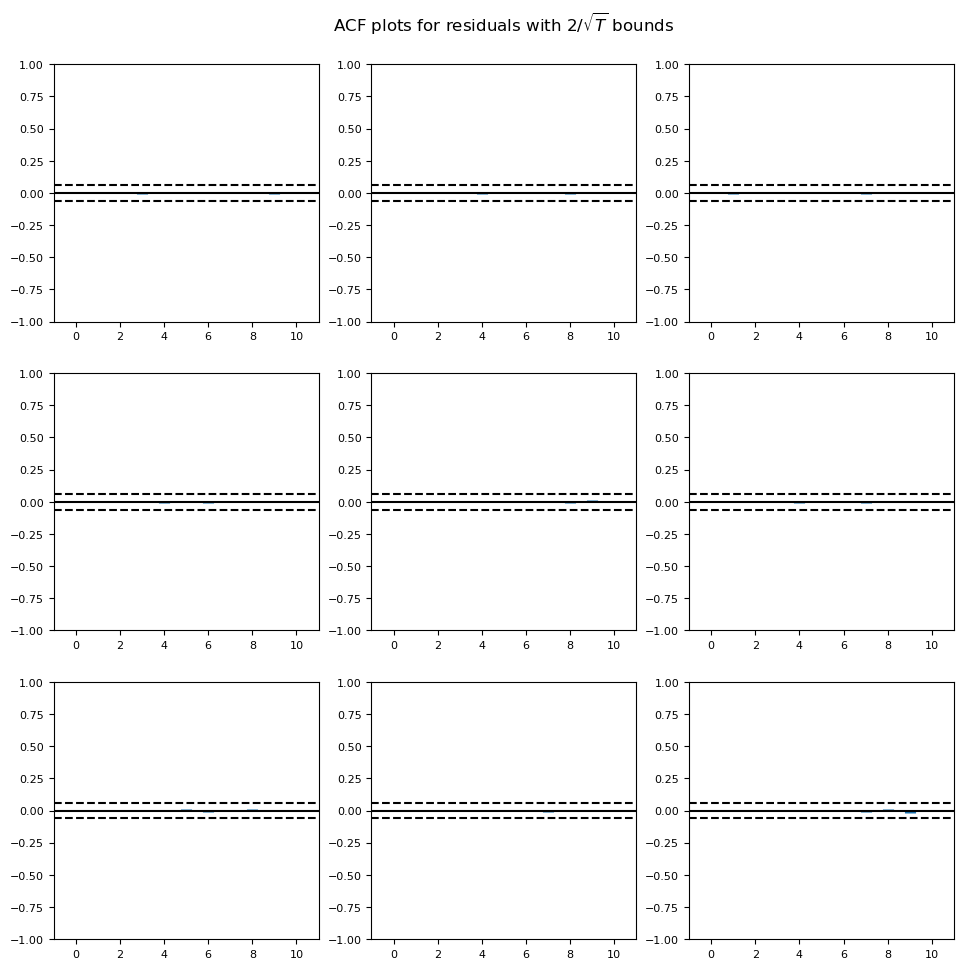

In [46]:
results.plot_acorr()
plt.show()

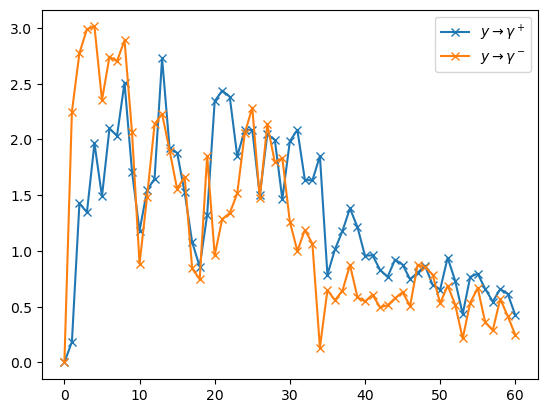

In [47]:
plt.plot(irf.irfs[:,1,0], marker='x', label=r'$y \rightarrow \gamma^+$')
plt.plot(irf.irfs[:,2,0], marker='x', label=r'$y \rightarrow \gamma^-$')
plt.legend()